## Introduction

This Jupyter notebook presents an financial analysis and hedging strategy for optimizing portfolio performance. In this project, we leverage a diverse set of techniques, including Linear Regression, Mini-Max Subset Correlation, and XGBoost, to dynamically manage and hedge a portfolio of stocks. The project aims to provide insights into how to construct and evaluate hedging strategies to mitigate portfolio risk and enhance returns.


In [1]:
import numpy as np
from itertools import combinations
from math import log
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import datetime
import matplotlib.cm as cm
import time
import random
import xgboost as xgb
from sklearn.feature_selection import SelectKBest,f_regression,RFE
from sklearn.model_selection import train_test_split, TimeSeriesSplit,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

The `MMSC class` represents the `Mini-Max Subset Correlation optimization algorithm`, used for constructing and analyzing portfolios. It helps in finding the optimal weightings of assets in a portfolio, considering different hedging or trading strategies. Mini-Max Subset Correlation (MMSC) focuses on minimizing the correlation between different subsets of assets in the portfolio.

In [2]:
#-------------------------------------------
# #-------------------------------------------
class MMSC:
    def __init__(self,covar,maxSubsetSize):
        # Class constructor
        self.covar=covar
        if maxSubsetSize>=covar.shape[0]:
            maxSubsetSize=covar.shape[0]-1
        self.subsets=self.get_Subsets(range(covar.shape[0]),maxSubsetSize)
        self.weights,self.tErr,self.iter=0,0,0
        self.scorrel=0,0
#-------------------------------------------
    def solve(self,precision,seed,hedge=True):
        # Compute the MMSC holdings and stats
        w=np.zeros(shape=(seed.shape[0],seed.shape[1]))
        weights=np.zeros(shape=(seed.shape[0],seed.shape[1]))
        w[:]=seed[:]
        iterTotal,iterW,aim,msc,n,N,grad=0,0,0,1,len(w)-1,len(self.subsets)-1,list(range(3))
        if hedge==False:msc=0 # For a trading basket
        loop=True
        #1) Iterations
        while loop==True:
            iterTotal+=1
            iterW+=1
            #2) Aim size
            if iterW==1:
                aim=max(1,aim/(1+log(n)))
            else:
                aim=min(10**6,aim*(1+log(n)))
                w[:]=weights[:]
            #3) Iterate subsets
            for i in range(N):
                #4) Normalize holdings
                w=w/w[0]
            #5) Compute subset correl matrix
            scovar=self.get_SubsetCovar(w)
            scorrel=get_Correl(scovar)
            #6) Determine which leg to change
            avg=(sum(scorrel[:,-1])-1)/N
            err=[avg-scorrel[j,-1] for j in range(N)]
            iErr,tErr=0,0

            for j in range(N):
                tErr+=err[j]**2
                if hedge==True and scorrel[j,-1]>scorrel[iErr,-1]:iErr=j
                if hedge==False and scorrel[j,-1]<scorrel[iErr,-1]:iErr=j
            #7) Store new optimum
            if (hedge==True and scorrel[iErr,-1]<msc) or (hedge==False and scorrel[iErr,-1]>msc):
                weights[:]=w[:]
                iterW=0
                msc=scorrel[iErr,-1]
            #8) CtB's Taylor expansion
            grad[0]=err[iErr]/aim
            grad[1]=-(scovar[i,i]/scovar[-1,-1])**.5*(scorrel[i,iErr]-scorrel[iErr,-1]* scorrel[i,-1])
            grad[2]=.5*scovar[i,i]/scovar[-1,-1]*(scorrel[iErr,-1]+scorrel[i,-1]* (2*scorrel[i,iErr]-3*scorrel[iErr,-1]*scorrel[i,-1]))
            #9) Step size
            if grad[2]!=0:
                delta=(grad[1]**2-4*grad[2]*grad[0])**.5
                if grad[1]>=0:
                    delta=(-grad[1]+delta)/(2.*grad[2])
                else:
                    delta=(-grad[1]-delta)/(2.*grad[2])
            elif grad[1]!=0:
                delta=-grad[0]/grad[1]
            #10) Backpropagate subset step back to legs
            w=self.get_Backpropagate(w,delta,i)
            #11) Exit conditions
            tErr=(tErr/N)**.5 # Root mean squared deviation
            #if tErr<10**-precision:loop=False # –If exit by convergence
            if iterTotal>10**precision:loop=False
        scovar=self.get_SubsetCovar(weights)
        scorrel=get_Correl(scovar)
        self.weights,self.tErr,self.iter,self.scorrel=weights,tErr,iterTotal,scorrel
#-------------------------------------------
    def get_Seed(self,col,hedge):
        # Seed for basket
        if hedge==True:
            # Seeds for hedging basket, based on alternating OLS holdings
            a=np.zeros(shape=(self.covar.shape[0],self.covar.shape[1]))
            a[:]=self.covar[:]
            a=np.delete(a,col,0)
            a=np.delete(a,col,1)
            a=np.linalg.inv(a)
            b=self.covar[:,col]
            b=np.delete(b,col,0)
            c=a*b
            c=np.insert(c,col,-1,axis=0)
            return -c

        else:
            # Seeds for trading basket, based on the leg's betas to the basket
            a=np.zeros(shape=(self.covar.shape[0],1))
            for b in range(self.covar.shape[0]):
                a[b,0]=self.covar[b,b]/self.covar[0,0]
            return a
#-------------------------------------------
    def get_Backpropagate(self,w,delta,subset):
        # Backpropagates subset delta to the legs
        for leg in self.subsets[subset]:
            w[leg]=w[leg]*(1+delta)
        return w
#-------------------------------------------
    def get_Subsets(self,iterable,maxSubsetSize):
        # Generate all subsets up to maxSubsetSize, but including the full set
        subsets=[item for item in combinations(iterable,1)]
        for subsetSize in range(2,maxSubsetSize+1):
            for item in combinations(iterable,subsetSize):
                subsets.append(item)
        for item in combinations(iterable,self.covar.shape[0]): subsets.append(item)
        return subsets
#-------------------------------------------
    def get_SubsetCovar(self,w):
        # Computes covariances among all subsets
        subsetCovar=np.zeros(shape=(len(self.subsets),len(self.subsets)))
        for i in range(len(self.subsets)):
            for j in range(i,len(self.subsets)):
                for k in self.subsets[i]:
                    for l in self.subsets[j]:
                        subsetCovar[i,j]+=w[k]*w[l]*self.covar[k,l]
        subsetCovar[j,i]=subsetCovar[i,j]
        return subsetCovar
#------------------------------------------- #-------------------------------------------
def get_Sign(number):
    # Sign of the holding, needed to compute CtB
    if number==0:return 0
    if number>=0:return 1
    if number<=0:return -1
#-------------------------------------------
def get_Correl(covar):
    # Correl matrix from covar
    correl=np.zeros(shape=(covar.shape[0],covar.shape[1]))
    for i in range(covar.shape[0]):
        for j in range(i,covar.shape[1]):
            correl[i,j]=covar[i,j]/(covar[i,i]*covar[j,j])**.5
            correl[j,i]=correl[i,j]
    return correl
#-------------------------------------------
def getMMSC_weights(covar):
    precision = 2
    maxSubsetSize = covar.shape[0] - 1  # Set maxSubsetSize=1 for MDR
    hedge = True  # True for a hedging basket, False for trading basket

    mmsc = MMSC(covar, maxSubsetSize)

    seed = mmsc.get_Seed(0, hedge)
    mmsc.solve(precision, seed, hedge)

    return mmsc.weights

This function `calculates_covariance_matrix` from a given series of returns. It is a fundamental step in risk assessment and portfolio optimization. The function takes into account the specified number of months to estimate the covariance matrix, helping assess the risk associated with a set of assets.


In [3]:
def calculate_covariance_matrix(pricing_date, returns, num_months=12):
    """
    Calculate a covariance matrix from returns.

    Parameters:
    - pricing_date (datetime): Pricing date.
    - returns (pandas.DataFrame): DataFrame containing the entire return series.
    - num_months (int): Number of months for covariance estimation.

    Returns:
    - cov (ndarray): Covariance matrix.
    """
    t_minus_n = pricing_date + relativedelta(months=-num_months)
    relevant_returns = returns[t_minus_n:pricing_date]
    cov = np.cov(relevant_returns.values, rowvar=False)
    return cov

The `drop_highly_correlated_columns` function serves to identify and remove highly correlated columns from a given dataset`

In [4]:
def drop_highly_correlated_columns(data, cutoff=0.9):
    """
    Drop highly correlated columns from data.

    Parameters:
    - data (pandas.DataFrame): Input data.
    - cutoff (float): Correlation threshold for dropping columns.

    Returns:
    - data_filtered (pandas.DataFrame): Data with highly correlated columns removed.
    """
    corr_data = np.triu(np.corrcoef(data, rowvar=False), k=1)
    drop_indices = np.nonzero(corr_data > cutoff)
    data_filtered = data.drop(data.columns[drop_indices[1]], axis=1)
    return data_filtered

The `select_random_stocks` function is designed to randomly select a specified number of stocks from a given DataFrame containing time series data. It provides two outputs: a new DataFrame with the cumulative sum of the time series data for the selected stocks and the original DataFrame with those selected stocks removed.

In [5]:
def select_random_stocks(df, num_stocks):
    """
    Select 'num_stocks' randomly from the given DataFrame and return a new DataFrame
    containing the cumulative sum of the time series data for the selected stocks,
    and the original DataFrame with those stocks removed.

    Parameters:
    - df (pandas.DataFrame): Input DataFrame with stock data.
    - num_stocks (int): Number of stocks to select.

    Returns:
    - new_df (pandas.DataFrame): New DataFrame with cumulative sum of selected stocks' time series.
    - remaining_df (pandas.DataFrame): Original DataFrame with selected stocks removed.
    """
    if num_stocks <= 0 or num_stocks > len(df.columns):
        raise ValueError("Invalid value for 'num_stocks'. Must be between 1 and the number of stocks in the DataFrame.")

    all_stocks = df.columns.tolist()
    random.seed(42)
    selected_stocks = random.sample(all_stocks, num_stocks)
    print("Selected stocks: " + str(selected_stocks))
    new_df = pd.Series(df[selected_stocks].sum(axis=1), name='Sum')
    remaining_stocks = [stock for stock in all_stocks if stock not in selected_stocks]
    remaining_df = df[remaining_stocks]
    return new_df, remaining_df

The `select_best_stocks` function is responsible for selecting the best stocks for hedging purposes using Linear Regression. It identifies a subset of stocks that are most relevant for a specific target variable, helping in the construction of a hedging portfolio.

In [6]:
def select_best_stocks(X, y, limit):
    """
    Select the best stocks for hedging using Linear Regression.

    Parameters:
    - X (pandas.DataFrame): Feature data for stock selection.
    - y (pandas.Series): Target data for stock selection.
    - limit (int): Limit on the number of features to select.

    Returns:
    - weights (ndarray): Regression weights.
    - selected_features (pandas.DataFrame): DataFrame with the selected features.
    """
    n_best = 20
    val_fold = 5
    test_cv = 5

    anova_filter = SelectKBest(f_regression, k=n_best)
    lasso_cv = linear_model.LassoCV(cv=val_fold)
    feature_selection = RFE(lasso_cv, n_features_to_select=limit)
    linreg = linear_model.LinearRegression()

    estimators = [('anova_filter', anova_filter), ('fs', feature_selection), ('regressor', linreg)]
    pipe = Pipeline(estimators)

    tss = TimeSeriesSplit(test_cv)
    y_predict = pd.Series().reindex_like(y)
    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        pipe.fit(X_train, y_train)
        y_predict[test_index] = pipe.predict(X_test)
        s_train_fold = pipe.score(X_train, y_train)
        s_test_fold = pipe.score(X_test, y_test)

    s_train = s_train_fold.mean()
    s_test = s_test_fold.mean()
    pos = y_predict - y

    af_features = X_train.columns[pipe.named_steps['anova_filter'].get_support()]
    fs_features = af_features[pipe.named_steps['fs'].get_support()]
    weights = pipe.named_steps['regressor'].coef_

    return weights, X[fs_features]

The `xgboost_hedge` function is designed to perform hedging using XGBoost, a popular machine learning algorithm. It aims to build a hedging model to predict the behavior of a target variable  based on a set of features.

In [7]:
def xgboost_hedge(X, y):
    """
    Perform hedging using XGBoost.

    Parameters:
    - X (pandas.DataFrame): Feature data for hedging.
    - y (pandas.Series): Target data for hedging.

    Returns:
    - feature_importances (ndarray): Feature importances from XGBoost.
    """
    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    xgb_regressor = xgb.XGBRegressor()
    random_search = RandomizedSearchCV(
        xgb_regressor, param_distributions=param_grid, n_iter=10, scoring='neg_mean_squared_error',
        cv=tscv, n_jobs=-1, random_state=42
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    best_params = random_search.best_params_
    feature_importances = best_model.feature_importances_
    stock_names = X.columns

    return feature_importances

The `run_hedging` function is a central component. Below the step-by-step explanation:

1. **Data Preprocessing:**
   - Reads historical stock data from a CSV file, such as "nikkei_stock_data.csv."
   - Converts the index to datetime format for time-based analysis.
   - Handles missing data by removing columns with excessive missing values and forward-filling for the remaining ones.
   - Drops highly correlated stocks to reduce multicollinearity.

2. **Portfolio Construction:**
   - Randomly selects a subset of stocks from the dataset to create a portfolio.
   - The portfolio is represented as `df_ptf`, and the remaining stocks are retained in `df_Nikkei` for hedging.

3. **Iterative Monthly Hedging:**
   - Iterates over each month's data to compute hedging strategies and returns.
   - For each iteration, the following steps are executed:
     - Selects the stocks and time frame for the past 12 months.
     - Utilizes Linear Regression to determine the best stocks for hedging (`select_best_stocks` function).
     - Calculates the covariance matrix for the selected stocks using the `calculate_covariance_matrix` function.
     - Computes the weights for hedging using the Mini-Max Subset Correlation (`getMMSC_weights`) and XGBoost (`xgboost_hedge`) techniques.
     - Trims the hedging stocks and portfolio for the next month.

4. **Hedging Performance Analysis:**
   - Calculates and compares the performance of different hedging strategies.
   - Calculates key metrics such as standard deviation, mean return, Sharpe ratio, and performs the Augmented Dickey-Fuller (ADF) test for each strategy.
   - Displays the results in a summary DataFrame.

In [8]:
def run_hedging():
    #read data
    df_Nikkei = pd.read_csv("nikkei_stock_data.csv",index_col=0)

    # Convert the index to datetime
    df_Nikkei.index = pd.to_datetime(df_Nikkei.index.str.split(' ').str[0])

    #to delete
    #df_Nikkei = df_Nikkei.head(400)
    #--------

    # Check for null or NaN values for each column
    null_summary = df_Nikkei.isnull().sum()

    # Remove columns with more than 7 empty values
    columns_to_remove = null_summary[null_summary > 7].index
    df_Nikkei = df_Nikkei.drop(columns=columns_to_remove)

    # Fill empty values with the preceding value for the remaining columns
    df_Nikkei.fillna(method='ffill', inplace=True)

    #Drop highly correlated stocks
    df_Nikkei = drop_highly_correlated_columns(df_Nikkei, cutoff=0.95)
    print(df_Nikkei.shape)

    #Select randomly stocks to create ptf
    df_ptf, df_Nikkei = select_random_stocks(df_Nikkei, 5)

    retVal = df_Nikkei.copy()
    numOfMons = 12
    previous_date = df_Nikkei.index[0]
    list_df_returns = []
    for date in df_Nikkei.index:
        tminusN = date + relativedelta(months=-numOfMons)
        if tminusN < min(df_Nikkei.index):
            retVal.loc[date] = np.full((df_Nikkei.shape[1],), np.nan)
        elif previous_date.month != date.month:
            lists_weights = []
            tnextM = (date.replace(day=1) + datetime.timedelta(days=32)).replace(day=1)
            #Use last 12 months to computes weights
            df_Nikkei_previous12M = df_Nikkei[(df_Nikkei.index >= tminusN) & (df_Nikkei.index <= date)]
            df_ptf_previous12M = df_ptf[(df_ptf.index >= tminusN) & (df_ptf.index <= date)]

            #Select best stocks for hedging using LinearRegression
            linear_regression_weights, df_hedgeStocks = select_best_stocks(df_Nikkei_previous12M, df_ptf_previous12M, 5)
            list_stocks = df_hedgeStocks.columns
            lists_weights.append(['Linear',linear_regression_weights.ravel().tolist()])

            df_merged = pd.concat([df_ptf_previous12M, df_hedgeStocks], axis=1)
            df_merged_returns = df_merged.pct_change().dropna()
            cov = calculate_covariance_matrix(date, df_merged_returns, num_months=numOfMons)
            cov = np.matrix(cov)

            #XGBoost weights
            xgboost_weights = xgboost_hedge(df_hedgeStocks, df_ptf_previous12M)
            lists_weights.append(['XGBoost',xgboost_weights.ravel().tolist()])

            #MMSC weights
            MMSC_weights = getMMSC_weights(cov)
            MMSC_weights = MMSC_weights.ravel().tolist()[1:]
            MMSC_weights = [-x for x in MMSC_weights]
            lists_weights.append(['MMSC',MMSC_weights])

            #trim hedge stock and ptf for next moth to compute return
            df_hedgeStocks_nextM = df_Nikkei[(df_Nikkei.index >= previous_date) & (df_Nikkei.index < tnextM)][list_stocks]
            df_ptf_NextM = df_ptf[(df_ptf.index >= previous_date) & (df_ptf.index < tnextM)]

            df_strategies = pd.DataFrame()
            list_analysis_dollars = []
            # Iterate through the list of weights and calculate the equity returns for each strategy
            for list_weights in lists_weights:
                name = list_weights[0]
                weights = list_weights[1]

                #******* Dollars *******
                df_portfolio_hedging = df_hedgeStocks_nextM * weights

                sum_ptf = df_portfolio_hedging.sum(axis=1)
                hedging_strategy = df_ptf_NextM - sum_ptf

                hedging_strategy_return = hedging_strategy.pct_change().dropna()
                df_strategies[name] = hedging_strategy_return

                df_portfolio_hedging.columns = [name + "_" + 'stock_' + str(i) for i in range(len(df_portfolio_hedging.columns))]
                list_analysis_dollars.append(df_portfolio_hedging)

            list_df_returns.append(df_strategies)
        previous_date = date

    concatenated_df = pd.concat(list_df_returns)
    
    return concatenated_df

In [9]:
concatenated_df = run_hedging()

(1220, 170)
Selected stocks: ['9021.T', '6920.T', '4523.T', '3099.T', '2282.T']


In [16]:
def display_result(concatenated_df):
    #Plot cumulative returns
    plt.figure(figsize=(10, 7))
    
    for strategy in concatenated_df.columns:
        # Plotting gld_returns
        #plt.plot(((concatenated_df[strategy][:]+1).cumprod()),
         #         label= strategy + ' Returns')
        
        log_returns = np.log(concatenated_df[strategy] + 1)
        cumulative_log_returns = log_returns.cumsum()
        plt.plot(cumulative_log_returns, label=strategy + ' Cumulative Log Returns')

    # x-labeling
    plt.xlabel('Date', fontsize=12)

    # y-labeling
    plt.ylabel('Returns', fontsize=12)

    # Titlename
    plt.title('Hedging Strategies Cumulative Returns', fontsize=14)
    plt.legend()
    plt.show()
    
    #Plot daily returns
    plt.figure(figsize=(10, 7))
    
    for strategy in concatenated_df.columns:
        # Plotting gld_returns
        log_returns = np.log(1 + concatenated_df[strategy])
        plt.plot(log_returns, label=strategy + ' Log Return')

    # x-labeling
    plt.xlabel('Date', fontsize=12)

    # y-labeling
    plt.ylabel('Daily Returns', fontsize=12)

    # Titlename
    plt.title('Hedging Strategies Daily Log Returns', fontsize=14)
    plt.legend()
    plt.show()
    
    # Number of trading days in a year (adjust as needed)
    trading_days_per_year = 252

    # Initialize lists to store the results
    strategy_names = concatenated_df.columns
    std_list = []
    mean_list = []
    sharpe_list = []
    adf_pvalue_list = []

    # Calculate std, mean, Sharpe ratio, and ADF test for each strategy
    for strategy in strategy_names:
        returns = concatenated_df[strategy]

        # Annualized metrics
        std = np.std(returns) * np.sqrt(trading_days_per_year)
        mean = np.mean(returns)

        # Sharpe ratio without a risk-free rate (annualized)
        sharpe = mean / std * trading_days_per_year

        # ADF test to check for stationarity
        adf_result = adfuller(returns, autolag='AIC')
        adf_pvalue = adf_result[1]

        std_list.append(std * 100)
        mean_list.append(mean * 100)
        sharpe_list.append(sharpe)
        adf_pvalue_list.append(adf_pvalue)

    # Create a summary DataFrame for the results
    results_data = {
        'Strategy': strategy_names,
        'Daily Mean Return %': mean_list,
        'Annualized Vol %': std_list,
        'Sharpe Ratio': sharpe_list,
        'ADF Test P-Value': adf_pvalue_list
    }

    results_df = pd.DataFrame(results_data)
    
    return results_df

/Users/hichemheddar/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


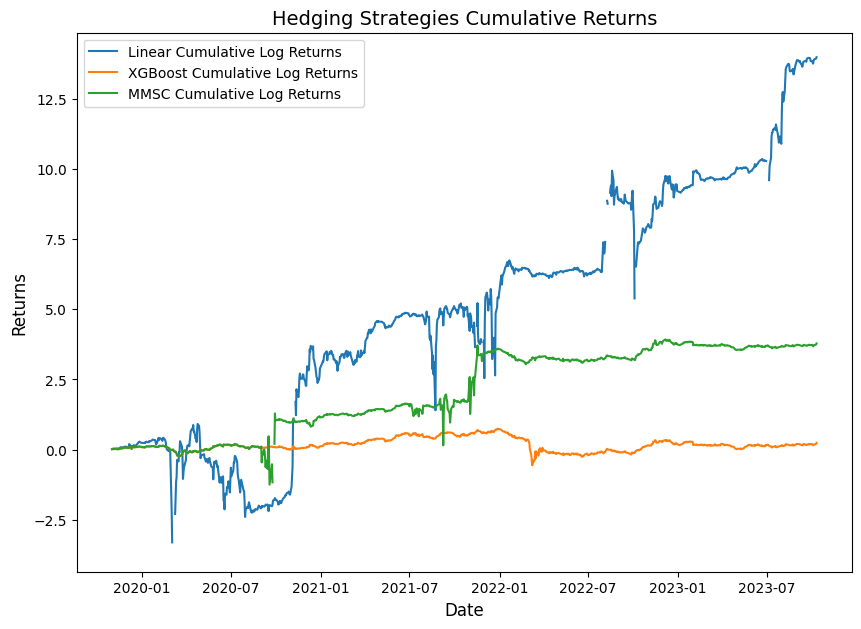

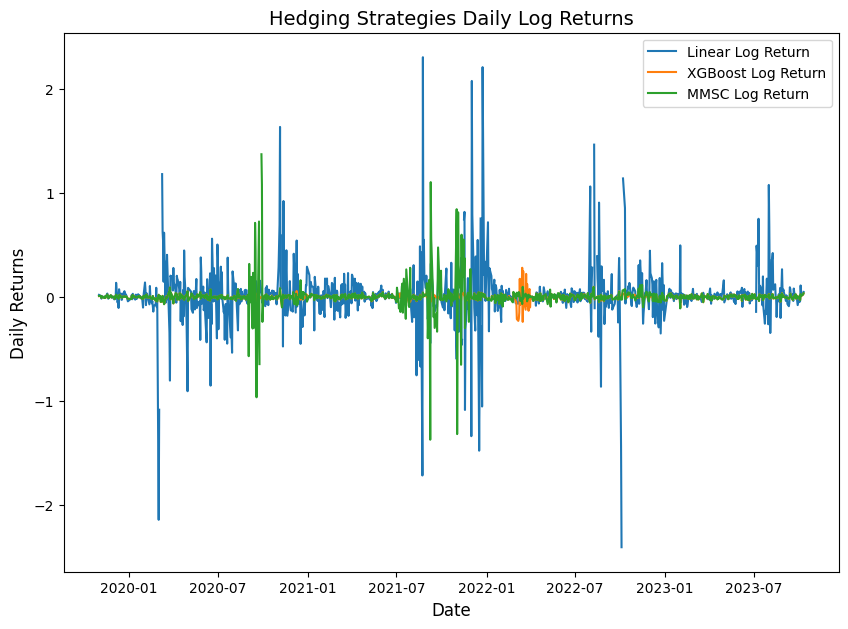

,Strategy,Daily Mean Return %,Annualized Vol %,Sharpe Ratio,ADF Test P-Value
0,Linear,0.672434,1450.439832,0.116829,0.000000e+00
1,XGBoost,0.075507,51.166435,0.371880,4.894337e-26
2,MMSC,1.228832,285.399173,1.085027,1.017355e-12


In [17]:
results_df = display_result(concatenated_df)
results_df